In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

2023-12-09 12:03:29.669048: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataset_dir='./sport_classification/dataset'
train_dir='./sport_classification/dataset/train'
test_dir='./sport_classification/dataset/test'

In [3]:
img = load_img(f'{train_dir}/00133e413b.jpg', target_size=(299,299))
x = np.array(img)
x.shape
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [4]:
base_model = keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling=None,
)

2023-12-09 12:03:41.194447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-09 12:03:41.228351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-09 12:03:41.229043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-09 12:03:41.230018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [5]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
result = base_model.predict(preprocess_input(X))
decode_predictions(result)

2023-12-09 12:03:51.062816: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-12-09 12:03:52.175404: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-09 12:03:52.175894: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-09 12:03:52.175929: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-12-09 12:03:52.176549: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-09 12:03:52.176654: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 5s 5s/step


[[('n04039381', 'racket', 0.58252186),
  ('n04409515', 'tennis_ball', 0.4119919),
  ('n02799071', 'baseball', 6.858602e-05),
  ('n02099849', 'Chesapeake_Bay_retriever', 5.510285e-05),
  ('n02108000', 'EntleBucher', 2.5542202e-05)]]

In [8]:
train_full_df = pd.read_csv(f'{dataset_dir}/train.csv')
train_full_df.columns = train_full_df.columns.str.lower()

train_df,val_df = train_test_split(train_full_df, test_size=0.2)
len(train_df),len(val_df)

(6581, 1646)

In [8]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_dataframe(
    train_df,
    directory=f'{train_dir}',
    x_col='image_id',
    y_col='label',
    target_size=(299,299), 
    batch_size=32)

Found 6581 validated image filenames belonging to 7 classes.


In [9]:
x,y= next(train_ds)
x.shape,y.shape

((32, 299, 299, 3), (32, 7))

In [10]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_dataframe(
    val_df,
    directory=f'{train_dir}',
    x_col='image_id',
    y_col='label',
    target_size=(299,299), 
    batch_size=32)

Found 1646 validated image filenames belonging to 7 classes.


In [11]:
learning_rate=0.01

base_model = keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling=None
)

base_model.trainable = False
inputs = keras.Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(100, activation='relu')(x)
outputs = keras.layers.Dense(7, activation='softmax')(x)
sport_model = keras.Model(inputs, outputs)

optimizer = keras.optimizers.Adam(learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
sport_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
sport_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dense_1 (Dense)             (None, 7)                 707       
                                                                 
Total params: 22,008,391
Trainable params: 205,607
Non-trainable params: 21,802,784
___________________________________________

In [12]:
#history01 = sport_model.fit(train_ds, epochs=10, validation_data=val_ds)

In [14]:
#history01.history

In [13]:
plt.plot(history01.history['accuracy'], label='train_acc')
plt.plot(history01.history['val_accuracy'], label='val_acc')
plt.legend()

NameError: name 'history01' is not defined

In [14]:
def make_model(lr, inner_layer_size):
    base_model = keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling=None)
    base_model.trainable = False
    inputs = keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(inner_layer_size, activation='relu')(x)
    outputs = keras.layers.Dense(7, activation='softmax')(x)
    sport_model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(lr)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    sport_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return sport_model


In [17]:
model = make_model(0.001,100)
history02 = sport_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
206/206 [==============================] - 69s 336ms/step - loss: 0.1626 - accuracy: 0.9474 - val_loss: 0.4120 - val_accuracy: 0.8906
Epoch 2/10
206/206 [==============================] - 68s 330ms/step - loss: 0.0859 - accuracy: 0.9695 - val_loss: 0.3489 - val_accuracy: 0.9168
Epoch 3/10
206/206 [==============================] - 67s 322ms/step - loss: 0.0572 - accuracy: 0.9777 - val_loss: 0.3434 - val_accuracy: 0.9222
Epoch 4/10
206/206 [==============================] - 68s 330ms/step - loss: 0.0644 - accuracy: 0.9775 - val_loss: 0.3782 - val_accuracy: 0.9186
Epoch 5/10
206/206 [==============================] - 68s 329ms/step - loss: 0.1174 - accuracy: 0.9652 - val_loss: 0.6403 - val_accuracy: 0.8809
Epoch 6/10
206/206 [==============================] - 66s 321ms/step - loss: 0.1015 - accuracy: 0.9681 - val_loss: 0.3594 - val_accuracy: 0.9222
Epoch 7/10
206/206 [==============================] - 68s 329ms/step - loss: 0.0919 - accuracy: 0.9698 - val_loss: 0.4019 - val_ac

In [15]:
scores={}
for lr in [0.01, 0.001, 0.0001, 0.005, 0.1]:
    print(lr)
    
    model = make_model(lr, 1000)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history
    
    print()
    print()

0.01
Epoch 1/10


/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


206/206 [==============================] - 72s 328ms/step - loss: 1.6325 - accuracy: 0.7815 - val_loss: 0.3202 - val_accuracy: 0.8931
Epoch 2/10
206/206 [==============================] - 64s 311ms/step - loss: 0.3033 - accuracy: 0.8950 - val_loss: 0.2884 - val_accuracy: 0.9040
Epoch 3/10
206/206 [==============================] - 64s 311ms/step - loss: 0.2299 - accuracy: 0.9211 - val_loss: 0.2799 - val_accuracy: 0.9095
Epoch 4/10
206/206 [==============================] - 63s 307ms/step - loss: 0.2108 - accuracy: 0.9245 - val_loss: 0.2921 - val_accuracy: 0.9016
Epoch 5/10
206/206 [==============================] - 65s 315ms/step - loss: 0.1674 - accuracy: 0.9397 - val_loss: 0.3347 - val_accuracy: 0.8931
Epoch 6/10
206/206 [==============================] - 66s 318ms/step - loss: 0.1514 - accuracy: 0.9429 - val_loss: 0.3750 - val_accuracy: 0.8949
Epoch 7/10
206/206 [==============================] - 63s 306ms/step - loss: 0.1676 - accuracy: 0.9447 - val_loss: 0.3632 - val_accuracy: 0.8

In [18]:
del scores[0.1]

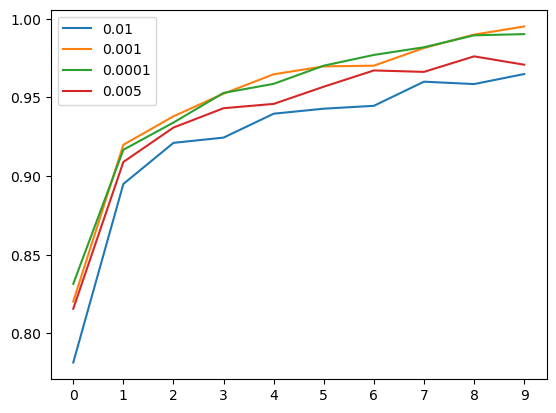

In [19]:
for lr,hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)
plt.xticks(np.arange(10))
plt.legend()   

In [21]:
del scores[0.005]
del scores[0.01]

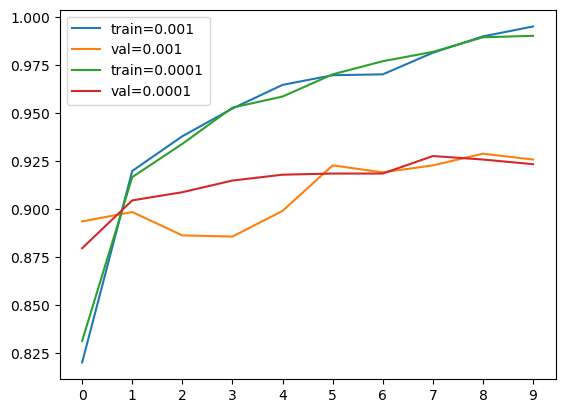

In [24]:
for lr,hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.xticks(np.arange(10))
plt.legend() 

In [25]:
final_leanrning_rate= 0.0001

In [27]:
scores={}
for size in [100,500,1000]:
    print(size)
    
    model = make_model(final_leanrning_rate, size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history
    
    print()
    print()

100
Epoch 1/10
206/206 [==============================] - 67s 310ms/step - loss: 0.9054 - accuracy: 0.7260 - val_loss: 0.5280 - val_accuracy: 0.8390
Epoch 2/10
206/206 [==============================] - 65s 315ms/step - loss: 0.4173 - accuracy: 0.8733 - val_loss: 0.3947 - val_accuracy: 0.8730
Epoch 3/10
206/206 [==============================] - 64s 309ms/step - loss: 0.3212 - accuracy: 0.9026 - val_loss: 0.3431 - val_accuracy: 0.8864
Epoch 4/10
206/206 [==============================] - 64s 311ms/step - loss: 0.2720 - accuracy: 0.9176 - val_loss: 0.3142 - val_accuracy: 0.8961
Epoch 5/10
206/206 [==============================] - 64s 311ms/step - loss: 0.2375 - accuracy: 0.9277 - val_loss: 0.2955 - val_accuracy: 0.9022
Epoch 6/10
206/206 [==============================] - 65s 317ms/step - loss: 0.2133 - accuracy: 0.9372 - val_loss: 0.2913 - val_accuracy: 0.9052
Epoch 7/10
206/206 [==============================] - 64s 309ms/step - loss: 0.1947 - accuracy: 0.9441 - val_loss: 0.2739 - va

In [31]:
del scores[100]

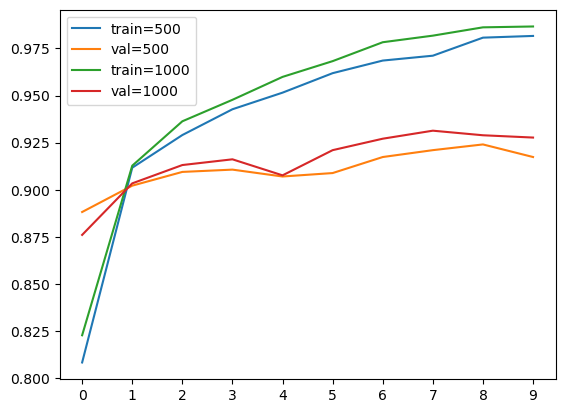

In [33]:
for size,hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % size))
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.xticks(np.arange(10))
plt.legend() 

In [34]:
final_leanrning_rate= 0.0001
final_size=1000

In [35]:
def make_model(lr, inner_layer_size, droprate):
    base_model = keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling=None)
    base_model.trainable = False
    inputs = keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(inner_layer_size, activation='relu')(x)
    x = keras.layers.Dropout(droprate)(x)
    outputs = keras.layers.Dense(7, activation='softmax')(x)
    sport_model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(lr)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    sport_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return sport_model

In [36]:
final_leanrning_rate= 0.0001
final_size=1000
scores={}
for droprate in [0.0,0.2,0.3,0.4,0.5,0.8]:
    print(droprate)
    
    model = make_model(final_leanrning_rate, final_size, droprate)
    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history
    
    print()
    print()

0.0
Epoch 1/30
206/206 [==============================] - 70s 323ms/step - loss: 0.5625 - accuracy: 0.8239 - val_loss: 0.3659 - val_accuracy: 0.8864
Epoch 2/30
206/206 [==============================] - 62s 303ms/step - loss: 0.2797 - accuracy: 0.9114 - val_loss: 0.3015 - val_accuracy: 0.8979
Epoch 3/30
206/206 [==============================] - 65s 317ms/step - loss: 0.2087 - accuracy: 0.9383 - val_loss: 0.2736 - val_accuracy: 0.9070
Epoch 4/30
206/206 [==============================] - 63s 308ms/step - loss: 0.1638 - accuracy: 0.9502 - val_loss: 0.2490 - val_accuracy: 0.9162
Epoch 5/30
206/206 [==============================] - 64s 311ms/step - loss: 0.1348 - accuracy: 0.9616 - val_loss: 0.2554 - val_accuracy: 0.9125
Epoch 6/30
206/206 [==============================] - 65s 315ms/step - loss: 0.1141 - accuracy: 0.9696 - val_loss: 0.2310 - val_accuracy: 0.9222
Epoch 7/30
206/206 [==============================] - 64s 308ms/step - loss: 0.0943 - accuracy: 0.9768 - val_loss: 0.2259 - va

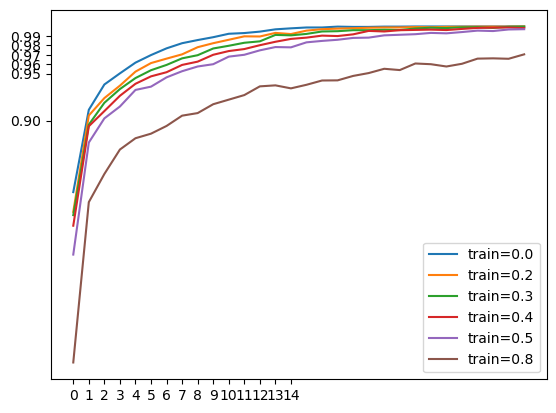

In [41]:
for rate,hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % rate))
    #plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.xticks(np.arange(15))
plt.yticks([0.90,0.95,0.96,0.97,0.98,0.99])
plt.legend() 

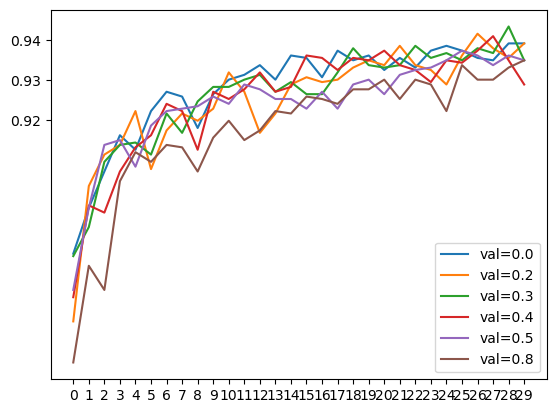

In [45]:
for rate,hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % rate))
    plt.plot(hist['val_accuracy'], label=('val=%s' % rate))
plt.xticks(np.arange(30))
plt.yticks([0.92,0.93,0.94])
plt.legend()

In [46]:
del scores[0.5]
del scores[0.8]

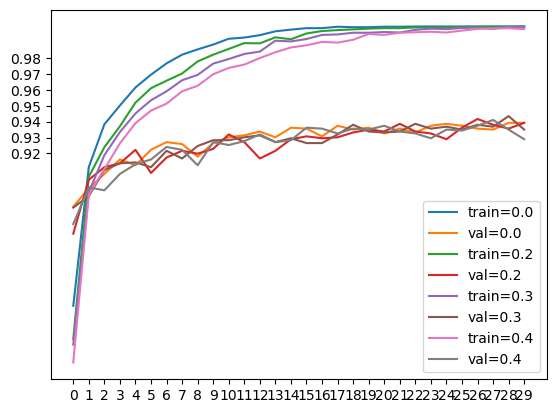

In [49]:
for rate,hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % rate))
    plt.plot(hist['val_accuracy'], label=('val=%s' % rate))
plt.xticks(np.arange(30))
plt.yticks([0.92,0.93,0.94,0.95,0.96,0.97,0.98])
plt.legend()

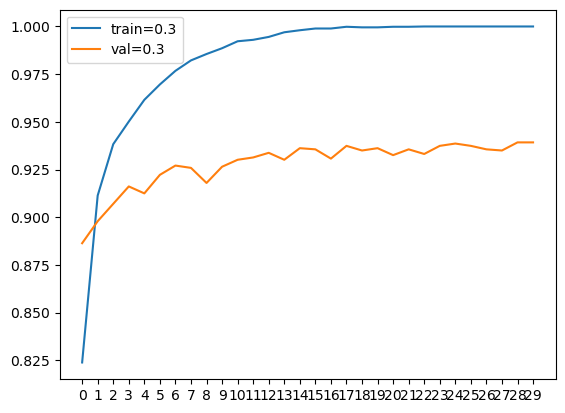

In [51]:
hist = scores[0.3]
plt.plot(hist['accuracy'], label=('train=%s' % 0.3))
plt.plot(hist['val_accuracy'], label=('val=%s' % 0.3))
plt.xticks(np.arange(30))

plt.legend()

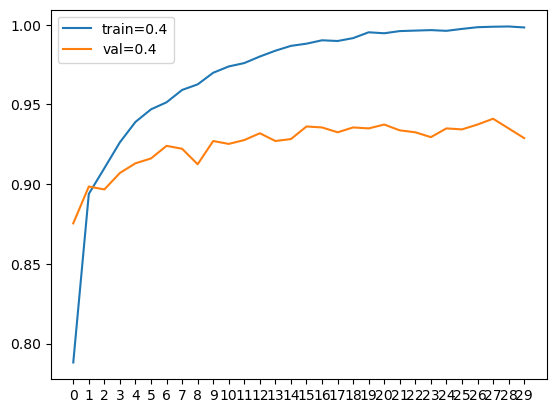

In [53]:
hist = scores[0.4]
plt.plot(hist['accuracy'], label=('train=%s' % 0.4))
plt.plot(hist['val_accuracy'], label=('val=%s' % 0.4))
plt.xticks(np.arange(30))

plt.legend()

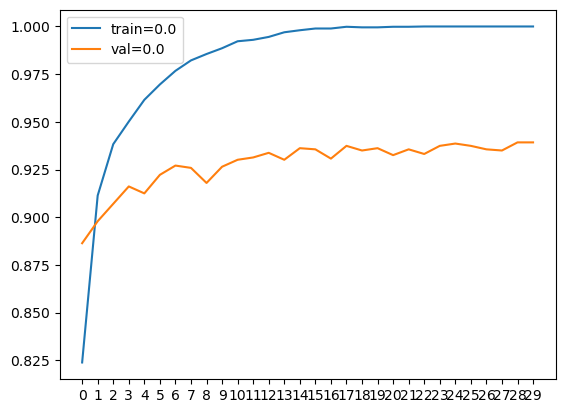

In [54]:
hist = scores[0.0]
plt.plot(hist['accuracy'], label=('train=%s' % 0.0))
plt.plot(hist['val_accuracy'], label=('val=%s' % 0.0))
plt.xticks(np.arange(30))

plt.legend()

In [15]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               shear_range=0.2,
                              zoom_range=0.2)
train_ds = train_gen.flow_from_dataframe(
    train_df,
    directory=f'{train_dir}',
    x_col='image_id',
    y_col='label',
    target_size=(299,299), 
    batch_size=32)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_dataframe(
    val_df,
    directory=f'{train_dir}',
    x_col='image_id',
    y_col='label',
    target_size=(299,299), 
    batch_size=32)

Found 6581 validated image filenames belonging to 7 classes.
Found 1646 validated image filenames belonging to 7 classes.


In [11]:
final_leanrning_rate= 0.0001
final_size=1000
final_drop_rate=0.3

In [12]:
def make_model(lr, inner_layer_size, droprate):
    base_model = keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling=None)
    base_model.trainable = False
    inputs = keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(inner_layer_size, activation='relu')(x)
    x = keras.layers.Dropout(droprate)(x)
    outputs = keras.layers.Dense(7, activation='softmax')(x)
    sport_model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(lr)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    sport_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return sport_model

In [17]:
model_file_name_pattern ='Inception_v1_{epoch:02d}_{val_accuracy:.3f}.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    model_file_name_pattern,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)


In [18]:
final_leanrning_rate= 0.0001
final_size=1000
final_drop_rate=0.3


model = make_model(final_leanrning_rate, final_size, final_drop_rate)
history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/30
206/206 [==============================] - 171s 812ms/step - loss: 0.6869 - accuracy: 0.7736 - val_loss: 0.3690 - val_accuracy: 0.8925
Epoch 2/30
206/206 [==============================] - 165s 802ms/step - loss: 0.3635 - accuracy: 0.8742 - val_loss: 0.3092 - val_accuracy: 0.8961
Epoch 3/30
206/206 [==============================] - 167s 809ms/step - loss: 0.3053 - accuracy: 0.8999 - val_loss: 0.2623 - val_accuracy: 0.9083
Epoch 4/30
206/206 [==============================] - 165s 802ms/step - loss: 0.2620 - accuracy: 0.9138 - val_loss: 0.2575 - val_accuracy: 0.9137
Epoch 5/30
206/206 [==============================] - 167s 811ms/step - loss: 0.2361 - accuracy: 0.9190 - val_loss: 0.2435 - val_accuracy: 0.9198
Epoch 6/30
206/206 [==============================] - 163s 789ms/step - loss: 0.2223 - accuracy: 0.9246 - val_loss: 0.2211 - val_accuracy: 0.9253
Epoch 7/30
206/206 [==============================] - 167s 811ms/step - loss: 0.1976 - accuracy: 0.9351 - val_loss: 0.2257 -